In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

import math
import os
import time
import sys

# unwarp the corners of the chessboard image
def cornersUnwarp(img, nx, ny, mtx, dist, corners):
    # Pass in your image into this function
    # Write code to do the following steps
    img_size = (img.shape[1], img.shape[0])
    # extra space for including more of the image
    xe = (corners[1][0][0] - corners[0][0][0])/2
    ye = (corners[nx][0][1] - corners[0][0][1])/2
    # source points
    src = np.float32((corners[0][0] - [xe, ye],
                    corners[nx-1][0] + [xe, -ye],
                    corners[(nx*ny)-1][0] + [xe, ye],
                    corners[nx*(ny-1)][0] - [xe, -ye]))
    tl, tr, br, bl = src
    # destination points
    dst = np.float32([[0, 0],
        [img_size[0] - 1, 0],
        [img_size[0] - 1, img_size[1] - 1],
        [0, img_size[1] - 1]])
    # get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# calibrate the camera and return the camera marix to be used later
def camCalibrate(img_name_list):
    for name in img_name_list:
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
        # If found, store imagepoint and object point data and draw corners
        if ret == True:
            objPoints.append(np.copy(objp))
            imgPoints.append(corners)
            #images.append(img)
    # get calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1],
                                                           None, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    return mtx, dist
    
# get calibrated image
def getCaliberatedImage(image, mtx, dist):
    undist = np.zeros_like(image)
    undist[:,:,0] = cv2.undistort(image[:,:,0], mtx, dist, None, mtx)
    undist[:,:,1] = cv2.undistort(image[:,:,1], mtx, dist, None, mtx)
    undist[:,:,2] = cv2.undistort(image[:,:,2], mtx, dist, None, mtx)
    return undist

def getIntensity(rgb):
    return (0.2126*rgb[0] + 0.7152*rgb[1] + 0.0722*rgb[2])

def getIntegralImage(img, is_square):
    iim = np.zeros_like(img)
    
    s_img = img
    if is_square:
        s_img = img**2
    
    for y in range(0, img.shape[0]):
        for x in range(0, img.shape[1]):
            if y > 0:
                if x > 0:
                    iim[y, x] = iim[y,x-1] + iim[y-1,x] - iim[y-1,x-1] + s_img[y,x]
                else:
                    iim[y, x] = iim[y-1,x] + s_img[y,x]
            else:
                if x > 0:
                    iim[y, x] = iim[y,x-1] + s_img[y,x]
                else:
                    iim[y, x] = s_img[y,x]
    return iim

def getIntensityImg(img):
    iimg = np.zeros((img.shape[0], img.shape[1]))
    for y in range(0, img.shape[0]):
        for x in range(0, img.shape[1]):
            iimg[y,x] = getIntensity(img[y,x])
    return iimg

def normMat(arr, mn, mx):
    return (arr - np.min(arr))*(mx - mn) / (np.max(arr) - np.min(arr))

## FBS-LC pipeline

0. Pre-calculations: integral images, indexed filter values
1. Cost computation: using Normalised cross-correlation
2. Cost aggregation: using bilateral filter and local consistency
3. Disparity optimisation using WTA
4. Left-right consistency check
5. Weighted least squares filter for smoothing



### Stage 1: Cost Computation
Use Normalised Cross-Correlation to calculate left and right volume cost. It provides robust results when calculating similarities in images with intensity differences.

#### Parameters and Variables
blockDelta ($\rho$) = 1<br>
blockSize = 2*blockDelta + 1<br>
blockPixels (n) = blockSize$^2$<br>
Standard Deviation for left image:
$$\sigma_l = \sqrt{\sum_{x=u-\rho}^{x=u+\rho} \sum_{y=v-\rho}^{y=v+\rho}
    i_l^2(x,y)/n - \mu_l^2
}$$
Standard Deviation for right image:$$\sigma_r = \sqrt{\sum_{x=u-\rho}^{x=u+\rho} \sum_{y=v-\rho}^{y=v+\rho}
    i_r^2(x-d,y)/n - \mu_r^2
}$$

where `i(x,y)` is the pixel intensity at `(x,y)` index and $\mu$ is the mean of pixel intensities in the respective block.

##### Precomputations
- compute $\mu$ as integral image
- compute $i^2(x,y)$ as integral square image
- compute $\sigma$ using $\mu$ and $i$ values

##### Cost Value
$$c(u,v,d) = {{\displaystyle\sum_{x=u-\rho}^{x=u+\rho} \displaystyle\sum_{y=v-\rho}^{y=v+\rho}
    i_l(x,y)i_r(x-d,y) - n\mu_l\mu_r
}\over n\sigma_l\sigma_r}$$

The value of c at the position of (u, v, d) in the left cost volume is the same as that at the position of (u − d, v, d) in the right cost volume. That means, cost volumes are generated by using right as reference image for pixels in left image.

In [2]:
def getIISum(lx, ty, rx, by, iimg):
    if rx == lx and by == ty:
        return iimg[by, rx]
    if ty == 0:
        if lx > 0:
            return iimg[by, rx] - iimg[by, lx-1]
        else:
            return iimg[by, rx]
    else:
        if lx > 0:
            return iimg[ty-1, lx-1] + iimg[by, rx] - iimg[by, lx-1] - iimg[ty-1,rx]
        else:
            return iimg[by, rx] - iimg[ty-1, rx]


def getCost(left_img_p, right_img_p, l_iimg, r_iimg, block_size, disp_num):
    b_delta = block_size//2
    n = block_size**2
    cost_l = np.zeros((left_img_p.shape[0]-block_size+1, left_img_p.shape[1]-block_size+1, disp_num))
    cost_r = np.zeros_like(cost_l)
    # get the mean integral image and square integral image
    l_mimg = getIntegralImage(l_iimg, False)
    l_siimg = getIntegralImage(l_iimg, True)
    r_mimg = getIntegralImage(r_iimg, False)
    r_siimg = getIntegralImage(r_iimg, True)
    # do block by block calculations
    for x in range(0, left_img_p.shape[1]-block_size+1):
        disp_lim = disp_num
        if x - disp_num < 0:
            disp_lim = x
        for y in range(0, left_img_p.shape[0]-block_size+1):
            ty = y
            by = y+block_size-1
            # get left values
            lx = x
            rx = x+block_size-1
            l_i = l_iimg[y:y+block_size, x:x+block_size]
            l_i2 = getIISum(lx, ty, rx, by, l_siimg)
            l_mu = getIISum(lx, ty, rx, by, l_mimg)
            sigma_l = (l_i2 - (l_mu**2)/n)**0.5
            for d in range(0, disp_lim):
                # get right values
                lx = x-d
                rx = lx+block_size-1
                r_i = r_iimg[y:y+block_size, lx:lx+block_size]
                r_i2 = getIISum(lx, ty, rx, by, r_siimg)
                r_mu = getIISum(lx, ty, rx, by, r_mimg)
                sigma_r = (r_i2 - (r_mu**2)/n)**0.5
                
                # get the left and right cost
                cost_l[y,x,d] = (np.sum(l_i*r_i)-(l_mu*r_mu)/n)/(sigma_l*sigma_r)
                cost_r[y,lx,d] = cost_l[y,x,d]
            #d = np.argmax(cost_l[y,x])
            #cost_l[y,x, 0] = d
            #cost_r[y,x-d, 0] = d
        try:
            prcnt = round((x*100)/(left_img_p.shape[1]-block_size+1), 2)
        except:
            print("!!")
        sys.stdout.flush()
        print(str(prcnt)+"%", end='\r')
    return cost_l, cost_r

### Stage 2: Cost Aggregation: Locally Consistent

$$
    Support = e^{-{\Delta_{f,g}\over\gamma_s}}.e^{-{{\Delta_{f,g}^{\psi}}\over\gamma_c}}
    .e^{-{{\Delta_{f',g'}}\over\gamma_s}}.e^{-{{\Delta_{f',g'}^{\psi}}\over\gamma_c}}
    .e^{-{{\Delta_{g,g'}}\over\gamma_t}}
$$i.e,
$$
    Support = e^{-{ {{\Delta_{f,g} + \Delta_{f',g'}}\over\gamma_s} + 
    {{\Delta_{f,g}^{\psi} + \Delta_{f',g'}^{\psi}}\over\gamma_c} + 
    {{\Delta_{g,g'}}\over\gamma_t}}}
$$
and
$$
    \Delta_{f,g} = euclidian\_distance\_between\_f\_and\_g
$$
$$
    \Delta_{f,g}^\psi = \sqrt{\sum_{c\in R,G,B}{(I_c(f) - I_c(g))^2}}
$$
$$
    \Delta_{g,g'}^\omega = \sqrt{\sum_{c\in R,G,B}{(I_c(g) - I_c(g'))^2}}
$$
where $\gamma_s$, $\gamma_c$ and $\gamma_t$ are empirically derived parameters.


In [3]:
def getDelta(ref, tgt):
    delta = ((ref - tgt)**2)
    delta = (delta[:,:,0]+delta[:,:,1]+delta[:,:,2])**0.5
    return delta

def getOmega(b_size):
    b_delta = b_size//2
    omg = np.zeros((b_size, b_size))
    for y in range(0, b_size):
        for x in range(0, b_size):
            omg[y,x] = ((y-b_delta)**2 + (x-b_delta)**2)**0.5
    return omg
    
def getLCAggCost(cost_l, cost_r, l_img, r_img, block_size, w, disp_num, gamma_s, gamma_c, gamma_t):
    b_delta = block_size//2
    bd = w//2
    acost_l = np.zeros_like(cost_l)
    acost_r = np.zeros_like(cost_r)
    lp_img = np.zeros((l_img.shape[0]+block_size-w, l_img.shape[1]+block_size-w, 3))
    rp_img = np.zeros((l_img.shape[0]+block_size-w, l_img.shape[1]+block_size-w, 3))
    lp_img[b_delta-bd:-b_delta+bd, b_delta-bd:-b_delta+bd] = l_img
    rp_img[b_delta-bd:-b_delta+bd, b_delta-bd:-b_delta+bd] = r_img
    delta_psi_fg = np.zeros((l_img.shape[0],l_img.shape[1], block_size, block_size))
    delta_psi_fg0 = np.zeros((l_img.shape[0],l_img.shape[1], block_size, block_size))
    
    # calculate the delta values
    for cy in range(0, cost_l.shape[0]):
        for cx in range(0, cost_l.shape[1]):
            Sr = lp_img[cy:cy+block_size, cx:cx+block_size]
            St = rp_img[cy:cy+block_size, cx:cx+block_size]
            delta_psi_fg[cy,cx] = getDelta(Sr, Sr[b_delta,b_delta])
            delta_psi_fg0[cy,cx] = getDelta(St, St[b_delta,b_delta])
    delta_omega_fg = getOmega(block_size)
    # get the plausibility for each set of volumes for each disparity
    for cy in range(0, cost_l.shape[0]):
        for cx in range(0, cost_l.shape[1]):
            disp_lim = disp_num
            if cx - disp_num < 0:
                disp_lim = cx
            for d in range(0, disp_lim):
                dx = cx-d
                #print(cy, cx, d, disp_lim)
                # for each window in cost volumes
                Sg = lp_img[cy:cy+block_size, cx:cx+block_size]
                Sg0 = rp_img[cy:cy+block_size, dx:dx+block_size]
                delta_psi_gg = getDelta(Sg, Sg0)
                ps = (delta_omega_fg * 2)/gamma_s
                ps += (delta_psi_fg[cy,cx] + delta_psi_fg0[cy,dx])/gamma_c
                ps += delta_psi_gg/gamma_t
                supp_l = np.sum(np.exp(-ps))
                acost_l[cy,cx,d] = supp_l*cost_l[cy,cx,d]
                acost_r[cy,dx,d] = supp_l*cost_r[cy,dx,d]
            prcnt = round(((cy*cost_l.shape[1] + cx)*100)/(cost_l.shape[0]*cost_l.shape[1]), 2)
            sys.stdout.flush()
            print(str(prcnt)+"%", end='\r')
    return acost_l, acost_r

### Stage 3: Disparity Optimisation

Apply winner takes all for left and right aggregated cost volumes.


In [4]:
def getOptimalDisparity(cost_l, cost_r, disp_num):
    disp_l = np.zeros((cost_l.shape[0], cost_l.shape[1]))
    disp_r = np.zeros_like(disp_l)
    for y in range(0, cost_l.shape[0]):
        for x in range(0, cost_l.shape[1]):
            disp_lim = disp_num
            if x - disp_num < 0:
                disp_lim = x
            d_l = np.zeros((disp_num))
            d_r = np.zeros((disp_num))
            for d in range(0,disp_lim):
                d_l[d] = cost_l[y,x,d]*cost_r[y,x-d,d]
                if x+d < cost_l.shape[1]:
                    d_r[d] = cost_l[y,x+d,d]*cost_r[y,x,d]
            disp_l[y,x] = d_l.argmax()
            disp_r[y,x] = d_r.argmax()
    return disp_l, disp_r

### Stage 4: Disparity Refinement

In [5]:
def getLRCRefinedDisparity(disp_l, disp_r, acost_l, threshold):
    #cmap = np.zeros_like(disp_l)
    dn = acost_l.shape[-1]
    for y in range(0, disp_l.shape[0]):
        for x in range(0, disp_l.shape[1]):
            rx = x-int(disp_l[y,x])
            if rx < 0:
                rx = 0
            ddif = np.abs(disp_l[y,x] - disp_r[y,rx])
            if 0 < ddif <= threshold:
                d = int(disp_l[y,x])
                lc = acost_l[y,x,d]
                mc = lc
                rc = lc
                if d > 0:
                    lc = acost_l[y,x,d-1]
                if d < dn-1:
                    rc = acost_l[y,x,d+1]
                if (mc > rc) and (mc > lc):
                    disp_l[y,x] = (lc - rc)/(2*(lc + rc - 2*mc)) + d
    return disp_l

def getOcclusionRefinedDisparity(disp_l, disp_r, disp_num):
    dn = acost_l.shape[-1]
    sset = False
    sx = 0
    for y in range(disp_l.shape[0]):
        x = disp_num
        while x < disp_l.shape[1]-1:
            rx = max(int(x - disp_l[y,x]), 0)
            if disp_l[y,x] != disp_r[y,rx]:
                if sset == False:
                    sx = x
                    sset = True
            else:
                if sset == True:
                    dlt = x-sx+1
                    for dx in range(x-1, sx-1, -1):
                        disp_l[y, dx] = disp_r[y, rx-(x-dx)]
                sset = False
            x += 1
    return disp_l

def getLineSegments(img, tau, L):
    segh = np.zeros((img.shape[0], img.shape[1], 2))
    #segv = np.zeros_like(segh)
    # create horizontal segment
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            al = 0
            ar = 0
            for lx in range(x, -1, -1):
                cd = np.max(img[y,x]-img[y, lx])
                if cd >= tau or abs(x-lx) > L or lx == 0:
                    al = abs(x-lx)
                    break
            for rx in range(x, img.shape[1]):
                cd = np.max(img[y,x]-img[y, rx])
                if cd >= tau or rx >= x+L-1 or rx == img.shape[1]-1:
                    ar = abs(x-rx)
                    break
            segh[y,x] = (max(al-1, 0), max(ar, 0))
        prcnt = round(((y)*100)/(img.shape[0]), 2)
        sys.stdout.flush()
        print(str(prcnt)+"%", end='\r')
    return segh


### Semi-global Weighted Least Squares filter for smoothing disparity
#### WLS formulation

$$
    E(U) = \sum_{i\in\Omega}(U_i - F_i)^2 + \lambda\sum_{i\in\Omega}\sum_{j\in N(i)}\omega_{i,j}(U_i - U_j)^2
    \qquad\qquad\qquad\qquad\qquad (1)
$$
Here, $\Omega$ represents the set of all coordinates. $\lambda$ is a parameter that balances the data term and smoothness term. $N(i)$ is the neighborhood of the pixel with coordinate $i$ which is a square patch of $(2r+1)\times(2r+1)$ centered at $i$. $\omega_{i,j}$ is the guidance weight based on $G$ which is given by the following equation:

$$
    \omega_{i,j} = \omega_{i,j}^{frac} = {1 \over{|i - j|^{\alpha_s} + \varepsilon}}.
    {1\over{|G_i - G_j|^{\alpha_r} + \varepsilon}}
    \qquad\qquad\qquad\qquad\qquad\qquad (2)
$$
where $\alpha_r$, $\alpha_s$ are constants defined by the user. $\varepsilon$ is small constant(0.0001) that prevents division by zero.

We need to solve: $$A.U = F\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (3)$$

Here $U$ and $F$ are vector representations of 2D images. Size of the images is $M\times N$.
$S = M\times N$. Size of $A$ is $S\times S$ and is defined as:
$$
    A_{i,j} = 
  \begin{cases}
    1 + \lambda\sum_{j\in N(i)} \omega_{i,j}       & \quad \text{for } i=j\\
    -\lambda\omega_{i,j}  & \quad \text{for } j\in N(i)\\
    0  & \quad \text{otherwise}
  \end{cases}\qquad\qquad\qquad\qquad\qquad\qquad (4)
$$

#### Neighborhood Construction of Subsystems
A pixel at row $s$ and column $t$ in image of size $M\times N$ is denoted as $I_{(s,t)}$. Fow a WLS model with $(2r + 1)\times(2r+1)$ neighborhood system, we first extract $2r+1$ columns around the $k_{th} (k = r+1, ... N-r)$ column.
Extracted pixels belong to the following set:
$$
    [I_{(*,k-r)},I_{(*,k-r+1)},...I_{(*,k)},...,I_{(*,k_r-1)},I_{(*,k+r)}]
$$
where $I_{(*,k)}$ denotes all pixels in $k_{th}$ column.

Connect these rows in sequence(from head-tow-head) to form one 1D vector.
<img src="./res/FGS_SGWLS_NC.png"></img>
$$\text{Figure: Illustration of neighborhood construction in subsystems of FGS and SG-WLS}$$

For each formed 1D vector, we can obtain a much smaller linear system as follows:
$$ A_s.u = f\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (5)$$
where $f$ is the formed 1D vector in the neighborhood construction step. $A_s$ is formed in similar way to $A_{(i,j)}$. The neighborhood system $N(i)$ here is one-dimensional $2r+1$ pixels.

$A_s$ has the following structure:
<img src="./res/A_s.png"></img>

here $s= (2r+1)M$ for neighborhood construction along column direction and $s = (2r+1)N$ for neighborhood construction along row direction.

For $r=1$, eqn(5) can be solved using LU decomposition, but for general case of $r >= 1$, `r-band LU decomposition` is used.

The process can be formulated as follows:
$$\qquad A_s = P.Q \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad  (6)$$
$$\qquad P.y = f \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (7)$$
$$\qquad Q.u = y \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (8)$$
Assuming P and Q have the following structures:
<img src="./res/P_Q.png"></img>
According to Eq.(6), for $i=1,...r$, we have:
$$
    \alpha_1 = a_1,\quad \gamma_{1,i} = c_{1,i},\quad \beta_{1,i} = \frac{b_{1,i}}{\alpha_1}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad (9)
$$

If $r>1$, then, for $k = 2,...,r$ and $i = 1, ..., r-k+1$, we have:
$$
    \alpha_k = a_k - \sum_{t=1}^{k-1}\gamma_{k-t,t}\beta_{k-t,t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$
$$
    \gamma_{k,i} = c_{k,i} - \sum_{t=1}^{k-1}\gamma_{k-t,i+t}\beta_{k-t,t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (10)
$$
$$
    \beta_{k,i} = {1\over{\alpha_k}}(b_{k,i} - \sum_{t=1}^{k-1}\beta_{k-t,i+t}\gamma_{k-t,t})
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$

If $r>2$, then, for $k = 3,...,r$ and $i = r-k+1, ..., r-1$, we have:
$$
    \gamma_{k,i} = c_{k,i} - \sum_{t=1}^{r-i}\gamma_{k-t,i+t}\beta_{k-t,t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (11)
$$
$$
    \beta_{k,i} = {1\over{\alpha_k}}(b_{k,i} - \sum_{t=1}^{r-i}\beta_{k-t,i+t}\gamma_{k-t,t})
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$

If $r\geq1$:<br>
For $k = r+1, ..., s$, we have:
$$
    \alpha_k = a_k - \sum_{t=1}^{r}\gamma_{k-t,t}\beta_{k-t,t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (12)
$$
For $k = r+1, ..., s-1$ and $i = 1, ..., min\{r-a,s-k\}$, we have:
$$
    \gamma_{k,i} = c_{k,i} - \sum_{t=1}^{r-i}\gamma_{k-t,i+t}\beta_{k-t,t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (13)
$$
$$
    \beta_{k,i} = {1\over{\alpha_k}}(b_{k,i} - \sum_{t=1}^{r-i}\beta_{k-t,i+t}\gamma_{k-t,t})
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$
For $k = 2, ..., s-r$, we have:
$$
    \gamma_{k,r} = c_{k,r} \text{,}\qquad \beta_{k,r} = {{b_{k,r}}\over{\alpha_k}}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (14)
$$

Eqs.(9) to (14) are the r-and LU decomposition in Eq.(6). When this is completed, we can solve Eq.(5) theough Eq.(7) and Eq.(8). When solving Eq.(7), we first have:
$$
    y_1 = {f_1\over\alpha_1}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (15)
$$
For $k = 2, ..., r$, we have:
$$
    y_k = {1\over\alpha_k}(f_k - \sum_{t=1}^{k-1}\gamma_{t,k-t}y_t)
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (16)
$$
For $k = r+1, ..., s$, we have:
$$
    y_k = {1\over\alpha_k}(f_k - \sum_{t=1}^{r}\gamma_{k-t,t}y_t)
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (17)
$$
When solving Eq.(8), we first have:
$$u_s = y_s\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (18)$$
For $k = s-1, ..., s-r+1$, we have:
$$
    u_k = y_k - \sum_{t=1}^{s-k}\beta_{k,t}\alpha_{k+t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (19)
$$
For $k = s-r, ..., 1$, we have:
$$
    u_k = y_k - \sum_{t=1}^{r}\beta_{k,t}\alpha_{k+t}
    \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad (20)
$$
The subsystem in Eq.(5) can be solved exactly through Eqs(9) to (20). Note that for $r = 1$, only Eqs.(9),(12),(14),(15),(17),(18) and (20) are needed. For $r = 2$, only Eq.(11) is not needed.

This smoothing process contains four steps.
1. The first step is the one-dimensional neighborhood construction described above. $2r + 1$ columns (along column direction) or rows (along row direction) in the original image are needed each time. This step results in 1D vectors of size $(2r + 1)M$ along column direction or (2r + 1)N along row direction. Each vector has a 2r + 1 neighborhood system.
2. The second step is solving the linear system with the formed 1D vector which is described above .
3. The third step is transforming the solution in the second step into an image patch of 2r + 1 rows/columns. This is a simple in-verse operation of the neighborhood construction in the first step.
4. The fourth step is averaging pixel values. This is because one pixel can be involved in several subsystems. These values in different subsystems of the same pixel are averaged as the final output.

The above steps are performed $T$ times along column and row direction alternatively to get the final smoothed image. Usually, $T = 2\sim4$ is appropriate for most applications.

In [6]:
def gbB(mat, k, i):
    return mat[k-1, i+k-1]

def ggC(mat, k, i):
    return mat[i+k-1, k-1]

def sbB(mat, k, i, v):
    mat[k-1, i+k-1] = v

def sgC(mat, k, i, v):
    mat[i+k-1, k-1] = v

def getSGWLS(disp, ref, lmda, r, alpha_s, alpha_r, T, nptype, omg_type, smooth):
    # iterate T times
    op_disp = np.zeros_like(disp)
    idisp = np.copy(disp)
    cdisp = None
    hdisp = np.zeros_like(idisp)
    vdisp = np.zeros_like(idisp)
    sc = 0.0001
    W = disp.shape[1]
    H = disp.shape[0]
    #S = W*H
    n = 2*r + 1
    Sh = H*n
    Sv = W*n
    lmda *= 1.5
    alps = 1/(2*(alpha_s**2))
    alpr = 1/(2*(alpha_r**2))
    # other placeholder variables
    fh_k, Gh_k, uh_k, yh_k = np.zeros((Sh)), np.zeros((Sh)), np.zeros((Sh)), np.zeros((Sh))
    Ah_s, Ph_s, Qh_s = np.zeros((Sh, Sh)), np.zeros((Sh, Sh)), np.zeros((Sh, Sh))
    
    fv_k, Gv_k, uv_k, yv_k = np.zeros((Sv)), np.zeros((Sv)), np.zeros((Sv)), np.zeros((Sv))
    Av_s, Pv_s, Qv_s = np.zeros((Sv, Sv)), np.zeros((Sv, Sv)), np.zeros((Sv, Sv)) 
    T_rep = T*2
    for rep in range(T_rep):
        # vertical pass
        if rep%2 == 0:
            D = H
            f, G, u, y, A, P, Q, s = fv_k, Gv_k, uv_k, yv_k, Av_s, Pv_s, Qv_s, Sv
            lmda /= 1.5
        else:
            D = W
            f, G, u, y, A, P, Q, s = fh_k, Gh_k, uh_k, yh_k, Ah_s, Ph_s, Qh_s, Sh
            
        for v in range(r, D-r):
            # get f
            v_mn = v-r
            v_mx = v+r+1
            if D == H:
                cdisp = vdisp
                if nptype == 1:
                    for i in range(W):
                        if i%2 != 0:
                            f[i*n:(i+1)*n] = (idisp[v_mn:v_mx, i])[::-1]
                            G[i*n:(i+1)*n] = (ref[v_mn:v_mx, i])[::-1]
                        else:
                            f[i*n:(i+1)*n] = idisp[v_mn:v_mx, i]
                            G[i*n:(i+1)*n] = ref[v_mn:v_mx, i]
                else:
                    # Working as edge detector
                    for i in range(v_mn, v_mx):
                        si = (i-v_mn)*W
                        ei = (i-v_mn+1)*W
                        fip = idisp[i]
                        rip = ref[i]
                        if i%2 != 0:
                            f[si:ei] = fip[::-1]
                            G[si:ei] = rip[::-1]
                        else:
                            f[si:ei] = fip
                            G[si:ei] = rip
                
            else:
                cdisp = hdisp
                if nptype == 1:
                    for i in range(H):
                        if i%2 != 0:
                            f[i*n:(i+1)*n] = (idisp[i, v_mn:v_mx])[::-1]
                            G[i*n:(i+1)*n] = (ref[i, v_mn:v_mx])[::-1]
                        else:
                            f[i*n:(i+1)*n] = idisp[i, v_mn:v_mx]
                            G[i*n:(i+1)*n] = ref[i, v_mn:v_mx]
                else:
                    for i in range(v_mn, v_mx):
                        si = (i-v_mn)*H
                        ei = (i-v_mn+1)*H
                        fip = idisp[:,i]
                        rip = ref[:,i]
                        if i%2 != 0:
                            f[si:ei] = fip[::-1]
                            G[si:ei] = rip
                        else:
                            f[si:ei] = fip
                            G[si:ei] = rip
                
            # create matrix Av_s of size Sv x Sv using f
            for i in range(s):
                sj = i-r
                ej = i+r+1
                if sj < 0:
                    sj = 0
                if ej > s:
                    ej = s
                sm_omg = 0.0
                for j in range(sj, ej):
                    if omg_type == 1:
                        omega_ij = lmda/((sc + abs(i-j)**alpha_s) * (sc + np.abs(G[j] - G[i])**alpha_r))
                    else:
                        omega_ij = lmda*( np.exp(-(((G[j]-G[i])**2)*alpr))  * np.exp(-(((i-j)**2)*alps)) )
                    sm_omg += omega_ij
                    A[j,i] = -omega_ij
                # over write for i = j case
                A[i,i] = 1 + sm_omg
            
            # Solve for P, Q
            P[0, 0] = A[0, 0]
            for i in range(1, r+1):
                P[i, 0] = A[i, 0]
                Q[0, i] = A[0, i]/P[0, 0]
            if r >= 2:
                # eqn.(10)
                for k in range(2, r+1):
                    P[k-1, k-1] = A[k-1, k-1] - sum([ggC(P, k-t, t)*gbB(Q, k-t, t) for t in range(1, k)])               # set alpha
                    alpha_i = 1/P[k-1, k-1]
                    for i in range(1, r-k+2):
                        sgC(P, k, i,
                            ggC(A, k, i) - sum([ggC(P, k-t, i+t)*gbB(Q, k-t, t) for t in range(1, k)])
                                  ) # set gamma
                        sbB(Q, k, i,
                            (gbB(A, k, i) - sum([gbB(Q, k-t, i+t)*ggC(P, k-t, t) for t in range(1, k)]))*alpha_i
                                 ) # set beta
            if r >= 3:
                # eqn.(11)
                for k in range(3, r+1):
                    alpha_i = 1/P[k-1, k-1]
                    for i in range(r-k+2, r):
                        sgC(P, k, i,
                            ggC(A, k, i) - sum([ggC(P, k-t, i+t)*gbB(Q, k-t, t) for t in range(1, r-i+1)])
                                  ) # set gamma
                        sbB(Q, k, i,
                            (gbB(A, k, i) - sum([gbB(Q, k-t, i+t)*ggC(P, k-t, t) for t in range(1, r-i+1)]))*alpha_i
                                 ) # set beta
            for k in range(r+1, s+1):
                # eqn.(12)
                P[k-1, k-1] = A[k-1, k-1] - sum([ggC(P, k-t, t)*gbB(Q, k-t, t) for t in range(1, r+1)])
            for k in range(r+1, s):
                # eqn.(13)
                alpha_i = 1/P[k-1, k-1]
                for i in range(1, 1+min(r-1, s-k)):
                    sgC(P, k, i,
                        ggC(A, k, i) - sum([ggC(P, k-t, i+t)*gbB(Q, k-t, t) for t in range(1, r-i+1)])
                       )
                    sbB(Q, k, i,
                        alpha_i*(gbB(A, k, i) - sum([gbB(Q, k-t, i+t)*ggC(P, k-t, t) for t in range(1, r-i+1)]))
                       )
            for k in range(2, s-r+1):
                # eqn.(14)
                sgC(P, k, r, ggC(A, k, r))
                sbB(Q, k, r, gbB(A, k, r)/P[k-1, k-1])
            # Solve for y
            y[0] = f[0]/P[0,0]  # eqn.(15)
            if r >=2:
                for k in range(2, r+1):
                    y[k-1] = (f[k-1] - sum([ggC(P, t, k-t)*y[t-1] for t in range(1, k)]))/P[k-1, k-1]
            for k in range(r+1, s+1):
                y[k-1] = (f[k-1] - sum([ggC(P, k-t, t)*y[k-t-1] for t in range(1, r+1)]))/P[k-1, k-1]
            # Solve for u
            u[s-1] = y[s-1]
            if smooth == True:
                for k in range(s-1, s-r, -1):
                    # eqn.(19)
                    u[k-1] = y[k-1] - sum([gbB(Q, k, t)*u[k+t-1] for t in range(1, s-k+1)])
            else:
                for k in range(s-1, s-r, -1):
                    # eqn.(19)
                    u[k-1] = y[k-1] - sum([gbB(Q, k, t)*P[k+t-1,k+t-1] for t in range(1, s-k+1)])
            
            if smooth == True:
                for k in range(s-r, 0, -1):
                    # eqn.(20)
                    u[k-1] = y[k-1] - sum([gbB(Q, k, t)*u[k+t-1] for t in range(1, r+1)])
            else:
                for k in range(s-r, 0, -1):
                    # eqn.(20)
                    u[k-1] = y[k-1] - sum([gbB(Q, k, t)*P[k+t-1,k+t-1] for t in range(1, r+1)])
                
            if nptype == 1:
                if D==H:
                    for i in range(W):
                        if i%2 != 0:
                            vdisp[v_mn:v_mx,i] = (u[i*n:(i+1)*n])[::-1]
                        else:
                            vdisp[v_mn:v_mx,i] = u[i*n:(i+1)*n]
                else:
                    for i in range(H):
                        if i%2 != 0:
                            hdisp[i, v_mn:v_mx] = (u[i*n:(i+1)*n])[::-1]
                        else:
                            hdisp[i, v_mn:v_mx] = u[i*n:(i+1)*n]
            else:
                if D==H:
                    for i in range(0, 2*r+1):
                        u_part = u[i*W:(i+1)*W]
                        if i%2 != 0:
                            vdisp[v-r+i] = u_part[::-1]
                        else:
                            vdisp[v-r+i] = u_part
                else:
                    for i in range(0, 2*r+1):
                        u_part = u[i*H:(i+1)*H]
                        if i%2 != 0:
                            hdisp[:,v-r+i] = u_part[::-1]
                        else:
                            hdisp[:,v-r+i] = u_part
            prcnt = round(((rep*(D-2*r) + v)*100)/(T_rep*(D-2*r)), 2)
            sys.stdout.flush()
            print(str(prcnt)+"%", end='\r')
        # average the results
        cdisp = cdisp/(r+1)
        
        if rep%2 != 0:
            idisp = (hdisp+vdisp)/2
    return idisp


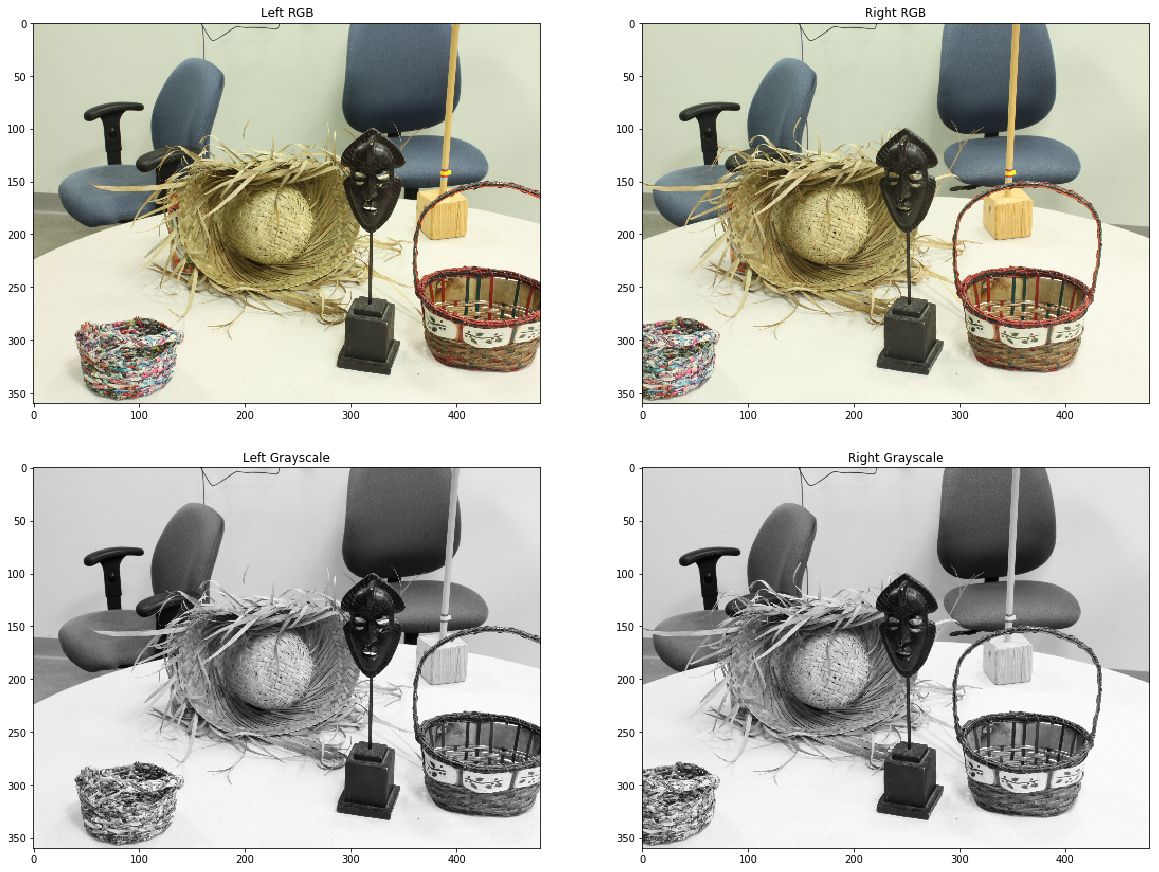

Left camera image dimensions: (360, 480, 3)
Right camera image dimensions: (360, 480, 3)


In [7]:
imgs_list = [('set1/im0.png','set1/im1.png'),
            ('set2/im0.png','set2/im1.png'),
            ('set3/im0.png','set3/im1.png'),
            ('cones/im2.png','cones/im6.png'),
            ('Playroom-perfect/im0.png','Playroom-perfect/im1.png'),
            ('Jadeplant-perfect/im0.png','Jadeplant-perfect/im1.png')]

# images from 0-5 index, change to test on different image sets
set_num = 0

img_left = cv2.imread('datasets/'+imgs_list[set_num][0])
img_right = cv2.imread('datasets/'+imgs_list[set_num][1])
img_left = cv2.resize(img_left, (480, 360))
img_right = cv2.resize(img_right, (480, 360))
img_left = img_left[:,:,::-1]
img_right = img_right[:,:,::-1]
#img_left = img_left[100:-30,:]
#img_right = img_right[100:-30,:]
# convert images to grayscale and normalize
gl = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
gr = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

gl = gl/(np.max(gl)-np.min(gl))
gr = gr/(np.max(gr)-np.min(gr))

fig1 = plt.figure(figsize=(20, 30))
fig1.add_subplot(1, 2, 1)
plt.title("Left RGB")
plt.imshow(img_left)

fig1.add_subplot(1, 2, 2)
plt.title("Right RGB")
plt.imshow(img_right)

fig1.add_subplot(2, 2, 3)
plt.title("Left Grayscale")
plt.imshow(gl, cmap="gray")

fig1.add_subplot(2, 2, 4)
plt.title("Right Grayscale")
plt.imshow(gr, cmap="gray")
plt.show()
# print image information
print("Left camera image dimensions:",img_left.shape)
print("Right camera image dimensions:", img_right.shape)

In [8]:
# Subpixel Fast Bilateral Stereo
# parameters
boxSize = 5
dispNum = int(round(img_left.shape[1]*0.23))
b_delta = boxSize//2

left_img_p = np.zeros((img_left.shape[0]+boxSize-1, img_left.shape[1]+boxSize-1, 3))
right_img_p = np.zeros((img_left.shape[0]+boxSize-1, img_left.shape[1]+boxSize-1, 3))
left_img_p[b_delta:-b_delta, b_delta:-b_delta] = img_left
right_img_p[b_delta:-b_delta, b_delta:-b_delta] = img_right
l_iimg = getIntensityImg(left_img_p)
r_iimg = getIntensityImg(right_img_p)

# cost computation
ts = time.time()

#n_img_left = img_left/(np.max(img_left)-np.min(img_left))
#n_img_right = img_right/(np.max(img_right)-np.min(img_right))

cost_l, cost_r = getCost(left_img_p, right_img_p, l_iimg, r_iimg, boxSize, dispNum)

te = time.time()
td = te-ts
print("Time taken:", str(td//60)+"m "+str(round(td%60, 3))+"s")

Time taken: 2.0m 11.15s


In [9]:
# cost aggregation
gamma_s = 12
gamma_c = 30
gamma_t = 25
wS = 21
ts = time.time()
acost_l, acost_r = getLCAggCost(cost_l, cost_r, left_img_p, right_img_p, wS, boxSize, dispNum, gamma_s, gamma_c, gamma_t)
te = time.time()
td = te-ts
print("Time taken:", str(td//60)+"m "+str(round(td%60, 3))+"s")

Time taken: 10.0m 21.174s


In [10]:
# disparity optimisation
ts = time.time()
l_disp, r_disp = getOptimalDisparity(acost_l, acost_r, dispNum)
te = time.time()
td = te-ts
print("Time taken:", str(td//60)+"m "+str(round(td%60, 3))+"s")

Time taken: 0.0m 13.793s


In [15]:
# disparity refinement
threshold = 2
nptype = 1
r = 1
T = 2
pset = 3

if pset == 0:
    # get noisy black & white image
    smooth = False
    omg_type = 1             # alpha = 1, sigma = 2
    alpha_s = 1.2
    alpha_r = 1.2
    lmda = 900
elif pset == 1:
    # get outline image
    smooth = False
    omg_type = 1
    alpha_s = 4
    alpha_r = 3
    lmda = 200
elif pset == 2:
    # get sharpened image
    smooth = True
    omg_type = 1
    alpha_s = 1.2
    alpha_r = 1.2
    lmda = 900
else:
    # get smoothed image
    smooth = True
    omg_type = 2             # alpha = 1, sigma = 2
    alpha_s = 1.2
    alpha_r = 1.2
    lmda = 2000

ts = time.time()
l_disp0 = getOcclusionRefinedDisparity(np.copy(l_disp), r_disp, dispNum)
disp_f = getLRCRefinedDisparity(l_disp, r_disp, acost_l, threshold)
#disp_f[disp_f > 0] = 1
norm_disp = np.uint8(normMat(disp_f, 0, 255))
#simg = np.float32(cv2.medianBlur(norm_disp, 3))
#simg = disp_f
#edges = cv2.Canny( np.uint8((gl - np.min(gl))*255 / (np.max(gl) - np.min(gl))),100,250)
#disp_wls_c = getSGWLS(simg, edges, lmda, r, alpha_s, alpha_r, T, nptype, omg_type, smooth)
disp_wls = getSGWLS(disp_f, gl, lmda, r, alpha_s, alpha_r, T, nptype, omg_type, smooth)
#disp_wls = getSGWLS(l_disp, gl, lmda, r, 4, 3, 1, nptype, 1, False)
te = time.time()
td = te-ts
print("Time taken:", str(td//60)+"m "+str(round(td%60, 3))+"s")

Time taken: 0.0m 33.797s


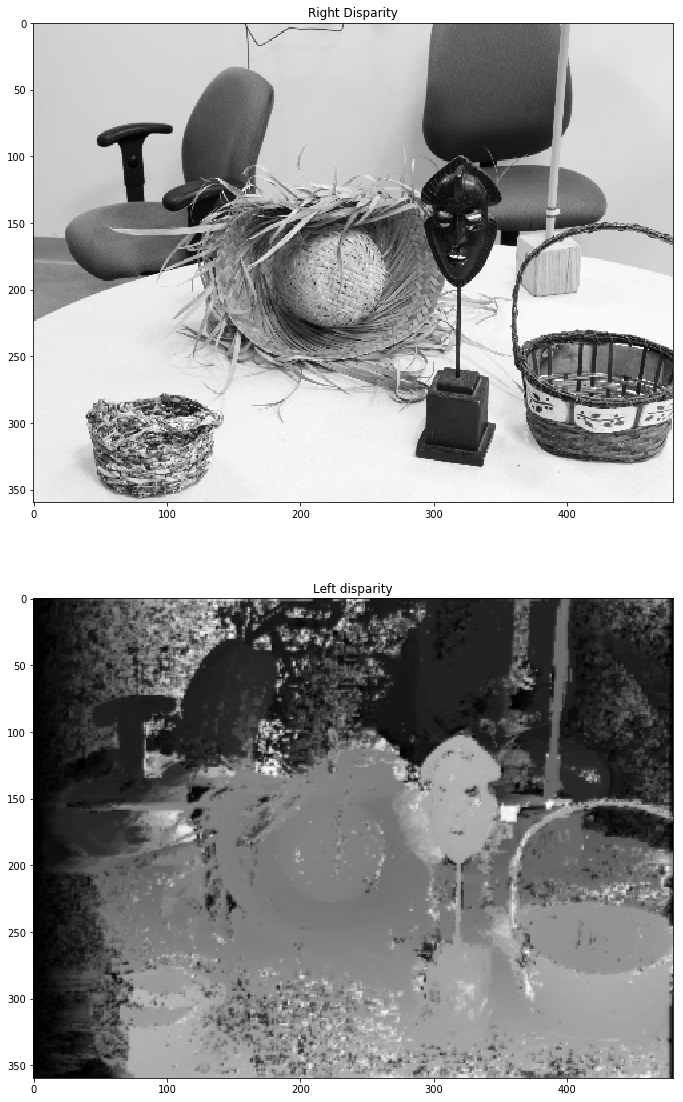

In [18]:
#disp = refineOcclusion(disp_f, 110)
norm_disp = np.uint8(normMat(disp_f, 0, 255))
#norm_disp[(norm_disp > dispNum)] = 0
ndisp = cv2.medianBlur(norm_disp, 1)

#edges = cv2.Canny( np.uint8((gl - np.min(gl))*255 / (np.max(gl) - np.min(gl))),50,150)
#disp_wls = getSGWLS(ndisp, gl, lmda, r, alpha_s, alpha_r, T, nptype, omg_type, smooth)
norm_disp_wls = np.uint8((disp_wls - np.min(disp_wls))*255 / (np.max(disp_wls) - np.min(disp_wls)))
#norm_disp_wls[(norm_disp_wls > dispNum)] = 0
ndisp_wls = cv2.medianBlur(norm_disp_wls, 1)
#ndisp = cv2.GaussianBlur(norm_disp, (5,1), 0)
#ndisp = cv2.bilateralFilter(norm_disp,9,75, 75)

fig1 = plt.figure(figsize=(30, 30))
fig1.add_subplot(3, 1, 1)
plt.title("Right Disparity")
plt.imshow(l_disp, cmap="gray")

fig1.add_subplot(3, 1, 2)
plt.title("Left disparity")
plt.imshow(ndisp_wls, cmap="gray")
plt.show()

In [13]:
fimg1 = np.copy(awdisp)
fimg2 = np.copy(awdisp)
fimg3 = np.copy(awdisp)
fimg4 = np.copy(awdisp)
fimg5 = np.copy(awdisp)
fimg1[(fimg1 <= 10) | (fimg1 > 15)] = 0
fimg2[(fimg2 <= 25) | (fimg2 > 30)] = 0
#fimg3[(fimg3 <= 40) | (fimg3 > 45)] = 0
fimg4[(fimg4 <= 55) | (fimg4 > 60)] = 0
fimg5[(fimg5 <= 100) | (fimg5 > 110)] = 0


fig1 = plt.figure(figsize=(20, 20))
fig1.add_subplot(1, 3, 1)
plt.title("Left Camera")
plt.imshow(img_left)

fig1.add_subplot(1, 3, 2)
plt.title("DSP1")
plt.imshow(fimg1, cmap="gray")

fig1.add_subplot(1, 3, 3)
plt.title("DSP2")
plt.imshow(fimg2, cmap="gray")

fig1.add_subplot(2, 3, 4)
plt.title("DSP3")
plt.imshow(ndisp, cmap="gray")

fig1.add_subplot(2, 3, 5)
plt.title("DSP4")
plt.imshow(fimg4, cmap="gray")

fig1.add_subplot(2, 3, 6)
plt.title("DSP5")
plt.imshow(fimg5, cmap="gray")
plt.show()

NameError: name 'awdisp' is not defined

In [13]:
p = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
l = p**2
d = dict()
for i in range(len(p)):
    d[p[i]] = l[i]

## Final Algorithm
### Cost computation
- Normalized cross correlation
- dsds